### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2017 ###

# Driving Recommendations to Minimize Fuel given Traffic Lights Information #

#### Ainur Ainabekova (ainabekova@wisc.edu) and Subasree Venkatsubhramaniyen (venkatsubhra@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Optional Subsection](#4.A.-Feel-free-to-add-subsections)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

This project aims to solve the problem of optimizing fuel consumption of the vehicle given the positions of traffic lights and their phase change timings. The model we have built gives recommendations to the vehicle in terms of its velocity and velocity changes at each second in order to minimize fuel for the whole trip without violating rules related to the traffic lights and speed limits on that route.

The idea of providing speed recommendations in order to minimize fuel popped up in our minds when we were in the Data Visualization class (CS765) where we saw visualization of traffic flow in San Francisco. We wanted to explore more about this visualization and that led to the Green Wave problem. [Green wave](https://en.wikipedia.org/wiki/Green_wave) is a phenomenon that takes place when a number of traffic lights are designed to coordinate continuous traffic flow where drivers have a chance to confront only green lights. This green wave idea recommends a speed on the route. This minimizes the wait time (assuming engine doesn't get turned off at the red light) of the vehicle and therefore reduces the fuel consumption. For example, United Parcel Service (UPS) trucks also try to reduce the fuel consumption rather than total time of the trip, and one part of their solution is to never take left turns. They discovered that this simple technique saves them 10 million gallons of fuel every year and they emit 20,000 tones less of carbon dioxide ["Why UPS never takes left"](http://theconversation.com/why-ups-drivers-dont-turn-left-and-you-probably-shouldnt-either-71432). This makes the problem interesting from two perspectives namely eco-friendly driving and cost saving which is not considered often as we do not account for all traffic lights along the route. 

![animation][GreenWave]

In our project we are not altering the timings of the traffic lights or we are not giving a recommedation for the traffic lights timings, we rather provide speed recommendations for a vehicle given the traffic lights data in advance. 

There have been mutiple research studies that attempt to solve problem. M. Barth, et. al. ["Dynamic ECO-Driving"](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5973594&tag=1) suggest dynamic eco-driving velocity planning algorithm for arterial corridors that specifies acceleration and deceleration profile design and optimizes fuel consumption with respect to traffic lights. Some of their advices are driving smoothly, avoiding high speeds and low speeds, accelerating slowly. As a result they obtained 10% to 15% fuel economy. 

Another study that inspired us was the [Green Light Optimized Speed Advisory - GLOSA](http://personal.ee.surrey.ac.uk/Personal/kk00085/papers/KK_GLOSA_IWCMC_11.pdf). Authors of this paper formulated an algorithm to improve the fuel consumption and reduce the traffic congestion. Algorithm considers information from traffic lights that have special devices that broadcast messages to vehicles. Speed velocity decisions can only be made when vehicle is close enough to receive messages from traffic light. GLOSA-equipped cars can save up to 7% of the fuel consumption. 

Our idea of speed recommendations can be embedded to the navigation systems like Google Maps whcih are aware of the routes and therefore can accommodate the information of traffic lights. We also believe our idea can be a realistic recommendation to a self-driving car.   

### Data? 

### Outline! 

[GreenWave]: https://upload.wikimedia.org/wikipedia/commons/f/f6/GreenWave.gif

## 2. Mathematical model ##

Our model is <b>Mixed Integer Linear Problem (MILP)</b>. Main decision variables namely velocity, acceleration, and position of the vehicle are modelled per second. All of them are continuous variables. There are a number of supporting variables for numerous logical constraints that are binary that make the model to be mixed integer in nature. 


#### Data parameters

- <b>T</b> - upper bound on the total time of the trip 
- <b>D</b> - destination's position, given assumption that initial position is 0
- <b>Light_pos</b> - an array of positions of lights 
- <b>t_r</b> and <b>t_g</b> - time until red and time until green for each traffic light. Each light can have its own phase of change of colors (assumption we start with green light). 

#### Decision Variables 

- <b>x</b> - array of size T that denotes vehicle's position at each second
- <b>v</b> - array of size T that denotes vehicle's velocity at each second
- <b>a</b> - array of size T that denotes vehicle's acceleration at each second

#### Motion constraints 

- Velocity at each second should not exceed maximum speed limit.
- Acceleration at each second should not exceed maximum acceleration limit and should not go below minimum limit.
- Initial and final velocities are 0.  
- Vehicle doesn't move beyond the destination position. 
- $v[i+1] = v[i] + a[i]$ 
- $x[i+1] = x[i] + a[i]/2 + v[i]$ 

### 2.1. Objective Function 

<b>Objective function</b> minimizes fuel consumption by penalizing four things: 

- Fuel consumption when the vehicle is moving
- Absolute change in the velocity, i.e. L1-norm of acceleration
- Absolute change in the acceleration, i.e. jerk
- Fuel consumption when vehicle waits at the red light with engine on

#### 2.1.1. Fuel consumption when vehicle is in motion

   Below is a plot of fuel consumption with respect to velocity. We can see that in general there is a mid-range of optimal velocities that lead to efficiency of engines, whereas more fuel is consumed at low and high speeds (aerodynamic resistance). 

<img src = "http://github.com/subasreev/CS524_Project/blob/master/FuelVsSpeed.jpg?raw=true" width="700">

   We converted this to piecewise linear function to make our objective linear: 
  
$$
f(v)=
\begin{cases}
0.1*(-13/2*v+59) & 0 \le v\le 8\\
0.1*7 & 8 \lt v\le 15\\
0.1*(3/4*v-17/4) & v\gt 15\\
\end{cases}
$$
 
<img src = "https://github.com/subasreev/CS524_Project/blob/master/PiecewiseFuel.png?raw=true" width = "600">
   
   This function should be used to count consumed fuel only when vehicle's engine is turned on, and vehicle has not yet reached the destination. After it reaches destination, we assume engine is turned off and fuel should not be counted according to this piecewise linear function. One of the ways we can handle this case is by creating a binary variable that will be 1 if the position of the vehicle is less than destination, and multiply it by the value of the piecewise linear function. But this would make the objective non-linear. Therefore, we modeled this piecewise function using SOS2 constraint. 
   
   For each segment of the piecewise function there is a binary variable (z_p) and a lambda associated with it. 

|             | v_endpoint  | f    | l   | g     |
| ------------|:-----------:| ----:|----:|------:|
| segment 1   | 8           |0.7   |8    |-13/2  |
| segment 2   | 8           |0.7   |7    |0      |
| segment 3   | 15          |0.7   |4    |3/4    |

   where (v, f) - (speed, fuel) end-point for a segment, l - segment length for x-axis, g - slope of the segment. 
    
   SOS2 constraints are designed to ensure that exactly one z_p=1, that is one segment is chosen, and corresponding consecutive lambdas are non-zero. This is true for each v[i]. 
    
   Each point on the function (v,f) follow these rules that we also have modeled: 
    
$$v =  \sum_{j=1}^m(z[j]*v\_endpoint[j] + sign( l[j] )*λ[j] )$$
$$fuel = \sum_{j=1}^m(z[j] * f[j] + sign( l[j] ) * g[j] * λ[j])$$

   where m is the number of segments in the piecewise function. 


#### 2.1.2. Objective as a function of the absolute change in velocity 

   We also need to minimize the L1-norm of the difference in velocity, i.e. acceleration. To do this we use epigraph technique to encode absolute values which allows us to make objective linear. This helps to achieve smooth driving which in turn reduces fuel consumption. 
    
#### 2.1.3. Objective as a function of the absolute change in acceleration 

   Similar to the section 2.2 we used epigraph technique to consider absolute change in the acceleration, i.e. jerk at each second during the trip. Rapid change in acceleration causes discomfort to the passengers as well as lowers gas mileage. 
    

#### 2.1.4. Fuel consumption while idling  

   Idling wastes fuel since you do not usually turn off engine at the red light. As the vehicle is accelerating from a dead stop, energy required for that is larger than from a moving velocity. 
   Idling time was computed based on how many seconds speed was equal to 0 and vehicle has not yet reached the destination. We have used binary variable z_7 for the case when velocity is 0, and binary variable z_8 for the case when position is less than the destination. Binary variable z_9 was used to encode the AND condition of these two cases. Finally, we sum the z_9 variable's values and multiply by the predefined value of fuel consumed per second whiile idling. 
    
    
### 2.2. Handling Traffic Lights 

Logical constraints with respect to traffic light (binary variables z_1, ..., z_6)
- when vehicle is very close to the traffic light and it is green, vehicle is allowed to move, which means x position of the vehicle can go past traffic light 
- when vehicle is very close to the traffic light and it is red, vehicle is not allowed to go beyond traffic light's position, therefore all the subsequent x positions of the vehicle until light goes green must be less than the traffic light's position 

 
### Finally, show the optimization problem written in standard form 



A discussion of the modeling assumptions made in the problem (e.g. is it from physics? economics? something else?). Explain the decision variables, the constraints, and the objective function. Finally, show the optimization problem written in standard form. Discuss the model type (LP, QP, MIP, etc.). Equations should be formatted in $\LaTeX$ within the IJulia notebook. For this section you may **assume the reader is familiar with the material covered in class**.

Here is an example of an equation:

$$
\begin{bmatrix}
  1 & 2 \\
  3 & 4
\end{bmatrix}
\begin{bmatrix} x \\ y \end{bmatrix} =
\begin{bmatrix} 5 \\ 6 \end{bmatrix}
$$

And here is an example of an optimization problem in standard form:

$$
\begin{aligned}
\underset{x \in \mathbb{R^n}}{\text{maximize}}\qquad& f_0(x) \\
\text{subject to:}\qquad& f_i(x) \le 0 && i=1,\dots,m\\
& h_j(x) = 0 && j=1,\dots,r
\end{aligned}
$$

For some quick tips on using $\LaTeX$, see [this cheat sheet](http://users.dickinson.edu/~richesod/latex/latexcheatsheet.pdf).

## 3. Solution ##

We are using libraries such as JuMP, Gurobi and PyPlot. 

In [1]:
# Data 
start_x = 0           # start position of the vehicle
destination = 800     # position of destination
idle_fuel = 0.1/3600  # gallons per second consumed when vehicle stops with engine on
max_v = 19            # maximum speed limit on the route
min_a = -5            # minimum acceleration, limit of the vehicle, m/s^2
max_a = 5             # maximum acceleration, limit of the vehicle, m/s^2
T = 180               # maximum time to reach destination, in seconds
  
# traffic lights data 
n_lights = 3                         # number of lights on the route
traf_pos = [300, 500, 700]           # positions of the traffic lights 
t_green_duration = [10, 25, 20]      # how long light stays green for traffic light i 
t_red_duration = [20, 24, 24]        # how long light stays yellow + red for traffic light i, yellow is before red
start_color = [0, 1, 0]              # with which color light cycle starts for traffic light i, [red, green,red]

#=
 Values necessary for SOS2 constraint. 
 Piecewise Linear Function to map velocity to fuel consumed at that velocity
    
    y1 = 0.1*(-13/2*v[i]+59)
    y2 = 0.1*7
    y3 = 0.1*(3/4*v[i]-17/4)

=#
v_end_point = [8, 8, 15]
v_func = [0.7, 0.7, 0.7]
l = [-8, 7, 4]
l_abs = abs(l)
l_sign = [-1, 1, 1]
g = [-13/20, 0, 3/40];

In [3]:
# Values for each traffic light at each second that define how long it remains red or green 
t_g = Array{Int64, 2}(n_lights, T)     # number of seconds left until traffic light i turns green for each jth second  
t_r = Array{Int64, 2}(n_lights, T)     # number of seconds left until traffic light i turns red for each jth second

# start_color = 0 means red, start_color = 1 means green 
# k - index of the traffic light
# This function helps to assign the start color to the traffic light k.
function init_lights(start_color,k)
    if start_color==0  # if red 
        for i=1:T
            j = i%(t_red_duration[k] + t_green_duration[k])
            if j<=(t_red_duration[k]-1)
                t_g[k, i] = t_red_duration[k] - j + 1
                t_r[k, i] = 0
            else
                t_g[k, i] = 0
                t_r[k, i] = t_green_duration[k] - j + t_red_duration[k]
            end
        end
    else             # if green 
        for i=1:T
            j = i%(t_red_duration[k] + t_green_duration[k])
            if j<=(t_green_duration[k]-1)
                t_g[k, i] = 0
                t_r[k, i] = t_green_duration[k] - j + 1
            else
                t_g[k, i] = t_red_duration[k] - j + t_green_duration[k]
                t_r[k, i] = 0
            end
        end
    end
end

# Set the start color and cycle of the traffic lights 
for i=1:n_lights
    init_lights(start_color[i], i)
end

In [4]:
using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag = 0))

########################################## Variables #########################################

@variable(m, x[1:T] >=0 )                 # position at time t
@variable(m, 0 <= v[1:T] <= max_v)        # velocity at time t
@variable(m, min_a <= a[1:T-1] <= max_a)  # acceleration at time t      
@variable(m, w[1:T-1])                    # epigraph variable for the abs val of difference in velocity
@variable(m, w_a[1:T-2])                  # epigraph variable for the abs val of difference in acceleration (jerk)

# Binary variables for logical constraints z[k,i], kth light and ith second

@variable(m, z_1[1:n_lights, 1:T], Bin)   # iff z_1=1 then x[i] >= traf_pos of light k
@variable(m, z_2[1:n_lights, 1:T], Bin)   # iff z_2=1 then x[i] <= traf_pos of light k
@variable(m, z_3[1:n_lights, 1:T], Bin)   # if z_1=1 and z_2=1 then z_3 = 1; i.e. x[i] == traf_pos of light k
@variable(m, z_4[1:n_lights, 1:T], Bin)   # if x[i]>= traf_pos[k]-max_v then z_4=1
@variable(m, z_5[1:n_lights, 1:T], Bin)   # if x[i]<= traf_pos[k] then z_5=1
@variable(m, z_6[1:n_lights, 1:T], Bin)   # if z_4=1 and z_5=1 then z_6=1

# Binary variables for the logical constraints on the position and velocity of vehicle
@variable(m, z_7[1:T], Bin)              # if v[i]<=0 then z_7 = 1
@variable(m, z_8[1:T], Bin)              # if x[i]<=destination then z_8 = 1
@variable(m, z_9[1:T], Bin)              # if x[i]<=destination (z_8=1) and v[i]<=0 (z_7=1) then z_9 = 1

# Variables for the SOS2 constraint
@variable(m, z_p[1:T,1:3], Bin)
@variable(m, lambda[1:T,1:3] >= 0)

########################################## Constraints #########################################

@constraint(m, dynamics[i in 1:T-1], x[i+1] == x[i] + a[i]/2 + v[i]) # x = at^2*0.5 + vt
@constraint(m, velocity_change[i in 1:T-1], v[i+1] == v[i] + a[i])   # v = v_initial + at 
@constraint(m, x[T] == destination)                                  # we need to reach destination 
@constraint(m, x[1] == start_x)                                      # we need to start at given pos
@constraint(m, v[1] == 0)                                            # start at rest 
@constraint(m, v[T] == 0)                                            # end at rest

# SOS2 constraints to ensure choosing two consecutive end points of segments in 
# piecewise linear function, v vs fuel 
for i in 1:T
    @constraint(m, lambda[i,1] <= l_abs[1]*z_p[i,1])
    @constraint(m, lambda[i,2] <= l_abs[2]*(z_p[i,2] + z_p[i,1]))
    @constraint(m, lambda[i,3] <= l_abs[3]*(z_p[i,2] + z_p[i,3]))
    @constraint(m, sum(lambda[i,:]) <= sum(l_abs))
end
@expression(m, obj_t[i in 1:T], sum(z_p[i,j]*v_func[j] + l_sign[j]*g[j]*lambda[i,j] for j=1:3))
@expression(m, v_value[i in 1:T], sum(z_p[i,j]*v_end_point[j] + l_sign[j]*lambda[i,j] for j=1:3))
for i in 1:T                                    
    @constraint(m, v_value[i] == v[i])
end 
                                                                 
for i=1:T-1
    # Epigraph constraint for abs value of acceleration 
    @constraint(m, w[i] >= a[i])
    @constraint(m, -w[i] <= a[i])
    
    # Epigraph constraint for abs value of difference in acceleration
    if i <= T-2
        @constraint(m, w_a[i] >= a[i+1]-a[i])
        @constraint(m, -w_a[i] <= a[i+1]-a[i])
    end
end

# Constraints to check whether vehicle should stop or move when it's close to the traffic light
for k = 1:n_lights
    for i=1:T
        
        # constraints for checking if x[i] == traf_pos[k] 
        @constraint(m, x[i]- traf_pos[k] <= traf_pos[k]*2*z_1[k, i] - (1-z_1[k, i])) 
        @constraint(m, x[i] - traf_pos[k] >= -traf_pos[k]*(1-z_1[k, i]))
        @constraint(m, x[i]- traf_pos[k] >= -traf_pos[k]*z_2[k, i] + (1-z_2[k, i]))
        @constraint(m, x[i]- traf_pos[k] <= traf_pos[k]*2*(1-z_2[k, i])) 
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 <= 2*z_3[k, i] - (1-z_3[k, i]))
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 >= -2*(1-z_3[k, i]))
                                
        # constraints for x[i] being close to traf_pos[k]
        @constraint(m, x[i] - (traf_pos[k]-max_v) <= traf_pos[k]*2*z_4[k, i] - 0.1*(1-z_4[k, i]))
        @constraint(m, x[i] - (traf_pos[k]-max_v) >= -(traf_pos[k]-max_v)*(1-z_4[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) >= -(traf_pos[k])*z_5[k, i] + 0.1(1-z_5[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) <= traf_pos[k]*2*(1-z_5[k, i]))
        @constraint(m, z_4[k, i] + z_5[k, i] - 2 <= 2*z_6[k, i] - (1-z_6[k, i]))
        @constraint(m, z_4[k, i] + z_5[k, i] - 2 >= -2*(1-z_6[k, i]))

        # enters this loop if light is red, t_g is positive 
        for j=i:i+t_g[k, i]
            if j<=T
                # if z_6=1 then x[i+1] ... x[i+t_g[i]] <= traf_pos[k] 
                # if it is red color, and you are close to the traf_pos[k], don't cross red light until green  
                @constraint(m, x[j]-(traf_pos[k]) <= 2*(traf_pos[k])*(1-z_6[k, i])) 
                # if z_3=1 then v[j] = 0, last speed =0 when stops
                # if it is red and you are exactly at traf_pos[k], stop immediately 
                @constraint(m, v[j] <= max_v*(1-z_3[k, i]))                
            end
        end
    end
end

for i=1:T
                            
    # z_7[i] = 1, if v[i]=0, ignore first and last as they are defined to be 0
    if i>=2 && i <= T-1
        @constraint(m, v[i] >= -0.1*z_7[i]+(1-z_7[i]))
        @constraint(m, v[i] <= max_v*(1-z_7[i]))
    end
                            
    # this constraint is necessary to check whether x[i] is less than destination                
    @constraint(m, x[i] - (destination-0.01) >= -(destination-0.01)*z_8[i] + 0.01(1-z_8[i])) 
    @constraint(m, x[i] - (destination-0.01) <= destination*2*(1-z_8[i]))  # if z_8=1 then x<= dest-0.01
    
    # if x[i] >= destination, means our velocity is 0, then do not count fuel after that point  
    # else use the piecewise linear function defined for velocity vs fuel
    @constraint(m, sum(z_p[i,:]) <= z_8[i])         # if z_8==0 then sum(z_p)<=0
    @constraint(m, sum(z_p[i,:]) >= z_8[i])         # if z_8==0 then sum(z_p)>=0
    @constraint(m, sum(z_p[i,:])-1 >= -1(1-z_8[i])) # if z_8==1 then sum(z_p)>=1
    @constraint(m, sum(z_p[i,:])-1 <= -1(1-z_8[i])) # if z_8==1 then sum(z_p)<=1   
                            
    # count the number of times speed is 0 only when x[i]<destination to count idling time 
    @constraint(m, z_7[i] + z_8[i] - 2 <= 2*z_9[i] - (1-z_9[i]))  
    @constraint(m, z_7[i] + z_8[i] - 2 >= -2*(1-z_9[i]))
end

########################################## Objective Function #########################################
                        
# 1) minimize fuel only until destination 
# 2) minimize absolute change in velocities at each second
# 3) minimize absolute change in acceleration at each second
# 4) minimize fuel spent while idling (waiting at the red light)
@objective(m, Min, sum(obj_t) + sum(w) + sum(w_a) + sum(z_9)*idle_fuel)

solve(m)
            
vopt = getvalue(v)
xopt = getvalue(x)

println("Objective value = ", getobjectivevalue(m))

Objective value = 99.64791617612542


## 4. Results and discussion ##

Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.

Use plots (see `PyPlot` examples from class), or you can display results in a table like this:

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned |\$1600 |
| col 2 is      | centered      |  \$12 |
| zebra stripes | are neat      |   \$1 |

### 4.A. Feel free to add subsections

#### 4.A.a. or subsubsections

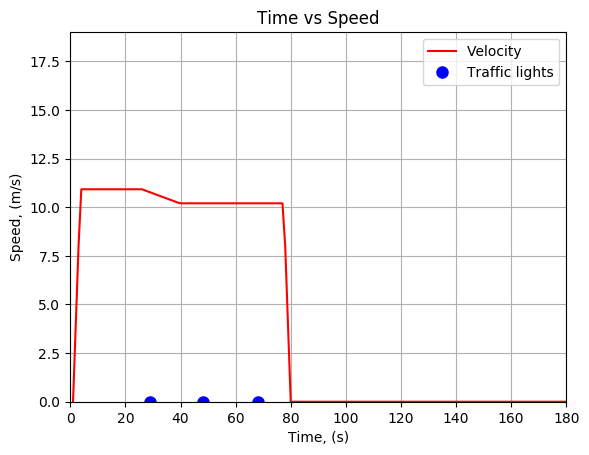

In [6]:
# Plot of the Time vs Speed, Blue dots indicate the time when vehicle is near traffic light  
using PyPlot
t = [1:T;]
grid("on")
ylim(0,max_v)
xlim(0,T)
plot(t, vopt, label="Velocity", "r")

time_at_light = zeros(n_lights)
for j = 1:n_lights
    for i=1:T
        if traf_pos[j]-max_v <= xopt[i] <= traf_pos[j] + max_v
            time_at_light[j] = i
            break
        end
    end
end
plot(time_at_light, zeros(n_lights), "bo", markersize=8, label="Traffic lights")
xlabel("Time, (s)")
ylabel("Speed, (m/s)")
title("Time vs Speed")
legend();

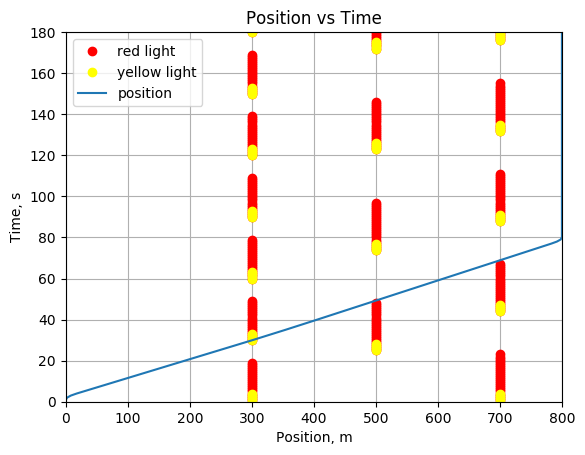

In [7]:
# Plot of Position vs Time (includes waiting time's position)
xlim(0,destination+100)

t_lights = zeros(n_lights, T)
t_yellow = zeros(n_lights, T)

for k=1:n_lights
    count = 0
    for i=1:T
        if t_r[k,i]==0
            if count < 4
                t_yellow[k,i] = i
            end
            count = count + 1
            t_lights[k,i] = i
        else # green 
            count = 0
        end
    end
end

traf_pos_x = zeros(n_lights, T)
for k=1:n_lights
    for i in 1:T
        traf_pos_x[k,i] = traf_pos[k]
    end
end
ctr1 = 0
ctr2 = 0
for k=1:n_lights
    for i=1:T
        if t_lights[k,i]>0
            if ctr1 == 0
                plot(traf_pos_x[k,i], t_lights[k,i], "ro", label="red light")
            else
                plot(traf_pos_x[k,i], t_lights[k,i], "ro")
            end
            ctr1 = ctr1 + 1
        end
    end
    for i=1:T
        if t_yellow[k,i]>0
            if ctr2 == 0
                plot(traf_pos_x[k,i], t_yellow[k,i], color="yellow", marker="o", linestyle="None", 
                    label="yellow light")
            else
                plot(traf_pos_x[k,i], t_yellow[k,i], color="yellow", marker="o", linestyle="None") 
            end
            ctr2 = ctr2 + 1
        end
    end
end
plot(xopt,t, label = "position")
ylim(0, T)
xlim(0, destination)
grid("on")
xlabel("Position, m")
ylabel("Time, s")
title("Position vs Time")
legend();

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.

1) data to simulate model , realistic Madison data 
2) make it stop 
3) examples for t_g and t_r 